In [6]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
from NeuralNetwork import NeuralNetwork, sigmoid
from Dense import Dense, Reshape
from Conv import Conv
from Tensor import Tensor
import matplotlib.pyplot as plt
import pyopencl as cl

from settings import context 

programConv = cl.Program(context, open('kernelsConv.cl').read()).build()

model = NeuralNetwork([Conv((5,5),3,0,(12,12,1),(1,1),sigmoid),Conv((5,5),3,0,(7,7,3),(1,1),sigmoid),Reshape((2, 2, 3),(16,)),Dense(16,10,sigmoid)])

In [3]:
Conv()

TypeError: __init__() missing 6 required positional arguments: 'kernel', 'filters', 'padding', 'inputShape', 'strides', and 'activation'

(10,)

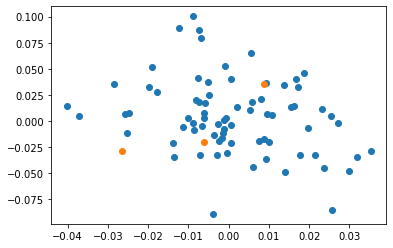

In [10]:
import numpy as np
from NeuralNetwork import NeuralNetwork, sigmoid
from Dense import Dense
from Conv import Conv
from Tensor import Tensor
import matplotlib.pyplot as plt
import pyopencl as cl


model = NeuralNetwork([Conv((5,5),3,0,(12,12,1),(1,1),sigmoid),Conv((5,5),3,0,(7,7,3),(1,1),sigmoid),Dense(16,10,sigmoid)])
model = NeuralNetwork([Conv((5,5),3,0,(12,12,1),(1,1),sigmoid),Conv((5,5),3,0,(7,7,3),(1,1),sigmoid),Dense(16,10,sigmoid)])
model.allocateMemory(1)
x = Tensor(np.random.randn(*(1,*model.inputShape)))
y = Tensor(np.random.randn(1,*model.outputShape))
model.gradientDescent(x,y,0)
dw,db = model.testGrads(x,y)

l = 0
plt.scatter(dw[l],model.layers[l].dw.get().flatten())
plt.scatter(db[l],model.layers[l].db.get().flatten())

In [3]:
model.layers[0].outputShape

(7, 7, 1)

In [6]:
5*5*3

75

In [5]:
model.layers[0].w.shape

(3, 5, 5, 3)

In [13]:
model.layers[1].outputShape

(2, 2, 4)

In [11]:
model.layers[1].dphi.shape

(1, 2, 2, 4)

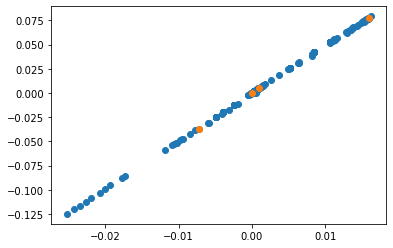

In [7]:
l = 1
plt.scatter(dw[l],model.layers[l].dw.get().flatten())
plt.scatter(db[l],model.layers[l].db.get().flatten())